In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from dataset.dataset import DepictionDataset
import onnx
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.autonotebook import tqdm, trange
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import pandas as pd
from torch.utils.data import random_split, DataLoader
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity
import torchvision

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# resnet tested on padded dataset
model_path        = r"C:\Users\linus\Documents\models\instanceRotation\ResNet34_57perc_20230824_16-49-09.pth"
dataset_base_path = r"C:\Users\linus\Documents\Datasets\InstanceRotation"
batch_size=256

model = torch.load(model_path, map_location=torch.device('cpu'))

whole_data = DepictionDataset(annotations_file=f"{dataset_base_path}/PaddedTraining.csv",
                            img_dir=f"{dataset_base_path}/PaddedTraining", 
                            img_size=(224, 224))

whole_data.set_mean((0.7826,)) 
whole_data.set_std((0.2941,))

train_split = 0.75
test_split = 1-train_split


# make the test data from the dataset
train_data, test_data = random_split(dataset=whole_data,
                                     lengths=[int(len(whole_data)*train_split), int(len(whole_data)*test_split)+1],
                                     generator=torch.Generator().manual_seed(442))

test_dataloader  = DataLoader(test_data, batch_size=batch_size)


model = model.to(device)
model.eval()
print(model)

C:\Users\linus\AppData\Local\Temp\ipykernel_14452\1757409606.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout(p=0.3, inplace=False)
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout(p=0.3, inplace=False)
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Con

In [5]:
y_true = []
y_predctions = []
with torch.no_grad():
    correct = total = 0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)       
        output = model(images)
        # _, prediction = torch.max(output.data, 1)
        y_true.extend(labels.tolist())
        y_predctions.extend(output.tolist())
        # total += label.size(0)
        # correct += (prediction == label).sum().item()
y_predictions = y_predctions

  0%|          | 0/17 [00:00<?, ?it/s]

In [6]:
y_pred = [i.index(max(i)) for i in y_predctions]

In [7]:
def transform_tensor_back(image_tensor: torch.Tensor, label: int) -> torch.Tensor:
    """Transforms a tensor based on a prediction. Transform "back" to the "original" image (label=0)"""
    flip = False if label < 4 else True
    if label == 0 or label == 4:
        angle = False
    elif label == 1 or label == 5:
        angle = 270
    elif label == 2 or label == 6:
        angle = 180
    elif label == 3 or label == 7:
        angle = 90
    image_tensor = torchvision.transforms.functional.rotate(image_tensor, angle) if angle is not False else image_tensor
    image_tensor = torchvision.transforms.functional.vflip(image_tensor) if flip is not False else image_tensor
    return image_tensor
def transform_tensor_forward(image_tensor: torch.Tensor, prediction: int) -> torch.Tensor:
    """Transforms a tensor based on a prediction. Transform "back" to the "original" image (label=0)"""
    flip = False if prediction < 4 else True
    if prediction == 0 or prediction == 4:
        angle = False
    elif prediction == 1 or prediction == 5:
        angle = 270
    elif prediction == 2 or prediction == 6:
        angle = 180
    elif prediction == 3 or prediction == 7:
        angle = 90
    image_tensor = torchvision.transforms.functional.vflip(image_tensor) if flip is not False else image_tensor
    image_tensor = torchvision.transforms.functional.rotate(image_tensor, angle) if angle is not False else image_tensor
    return image_tensor

def get_ambiguity_score(image, return_stats: False) -> float:
    if isinstance(image, np.ndarray):
        image = cv2.resize(image, (224, 224))
        image = image.astype("float32") / 255.0
        image = np.transpose(image, (2, 0,  1))
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
    image = image[0]
    image = image.unsqueeze(0)
    embedding1 = model(image)
    prediction = torch.argmax(embedding1, dim=1)
    
    reoriented_image = transform_tensor_back(image, prediction)
    
    embedding2 = model(reoriented_image)
    
    embedding1, embedding2 = embedding1.detach().numpy(), embedding2.detach().numpy()
    similarity = cosine_similarity(embedding1, embedding2)
    if return_stats: return similarity[0][0], (embedding1,  embedding2), reoriented_image
    else: return similarity[0][0]
    
def compare_answer_with_original(image, correct_label):
    if isinstance(image, np.ndarray):
        image = cv2.resize(image, (224, 224))
        image = image.astype("float32") / 255.0
        image = np.transpose(image, (2, 0,  1))
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
    image = image[0]
    image = image.unsqueeze(0)
    # rotate image to original orientation according to label
    original_orientation = transform_tensor_back(image, correct_label)
    original_embedding = model(original_orientation)
    prediction = torch.argmax(original_embedding, dim=1)
    
    # rotate image to predicted orientation
    predicted_orientation = transform_tensor_forward(original_orientation, prediction)
    predicted_embedding = model(predicted_orientation)
    
    original_embedding, predicted_embedding = original_embedding.detach().numpy(), predicted_embedding.detach().numpy()
    similarity = cosine_similarity(original_embedding, predicted_embedding)
    return similarity[0][0], (original_embedding, predicted_embedding), (image, predicted_orientation)
    
    

In [8]:
def get_embedding(image):
    image = image.unsqueeze(0)
    embedding = model(image)
    return embedding

def get_prediction_from_embedding(embedding):
    prediction = torch.argmax(embedding, dim=1)
    return prediction

def rotate_to_corr_orientation(image, ground_truth_label):
    rotated_back = torchvision.transforms.functional.rotate(image, int(90*(ground_truth_label%4))) # 0: -0°, 1: -90°, 2: -180°, 3: -270° ...
    flipped_back = torchvision.transforms.functional.hflip(rotated_back) if ground_truth_label > 3 else rotated_back
    return flipped_back

def rotate_to_pred_orientation(image, prediction):
    flipped = torchvision.transforms.functional.hflip(image) if prediction > 3 else image
    rotated = torchvision.transforms.functional.rotate(flipped, int(-90*(prediction%4))) # 0: 0°, 1: 90°, 2: 180°, 3: 270° ...
    return rotated

def compare_embeddings(embedding1, embedding2):
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

def inference_evaluation(testdata, index):
    input_image, true_label = testdata[index]
    original_embedding = model(input_image.unsqueeze(0))
    prediction = get_prediction_from_embedding(original_embedding)
    correct_oriented_image = rotate_to_corr_orientation(input_image, true_label)
    rotated_image = rotate_to_pred_orientation(correct_oriented_image, prediction)
    rotated_embedding = model(rotated_image.unsqueeze(0))    
    original_embedding, rotated_embedding = original_embedding.detach().numpy(), rotated_embedding.detach().numpy()
    similarity = compare_embeddings(original_embedding, rotated_embedding)

    return similarity, original_embedding[0], rotated_embedding[0], input_image.numpy()[0,:,:], rotated_image.numpy()[0,:,:], true_label, int(prediction)

In [9]:
print([0-90*(i%4) for i in range(8)])

[0, -90, -180, -270, 0, -90, -180, -270]


In [19]:
y_pred_corrected = y_pred.copy()
true_but_amgiuous = []
wrongly_predicted = []
for i in trange(len(y_pred)):
    if y_pred[i] != y_true[i]:
        similarity, original_embedding, rotated_embedding, input_image, rotated_image, true_label, prediction = inference_evaluation(test_data, i)
        if similarity > 0.91:
            eval_obj = {"similarity": similarity,
                        "original_embedding": original_embedding, 
                        "rotated_embedding": rotated_embedding, 
                        "input_image": input_image, 
                        "rotated_image": rotated_image,
                        "true_label": true_label,
                        "prediction": prediction}
            true_but_amgiuous.append(eval_obj)
            y_pred_corrected[i] = y_true[i]
        else:
            wrongly_predicted.append(i)

  0%|          | 0/4152 [00:00<?, ?it/s]

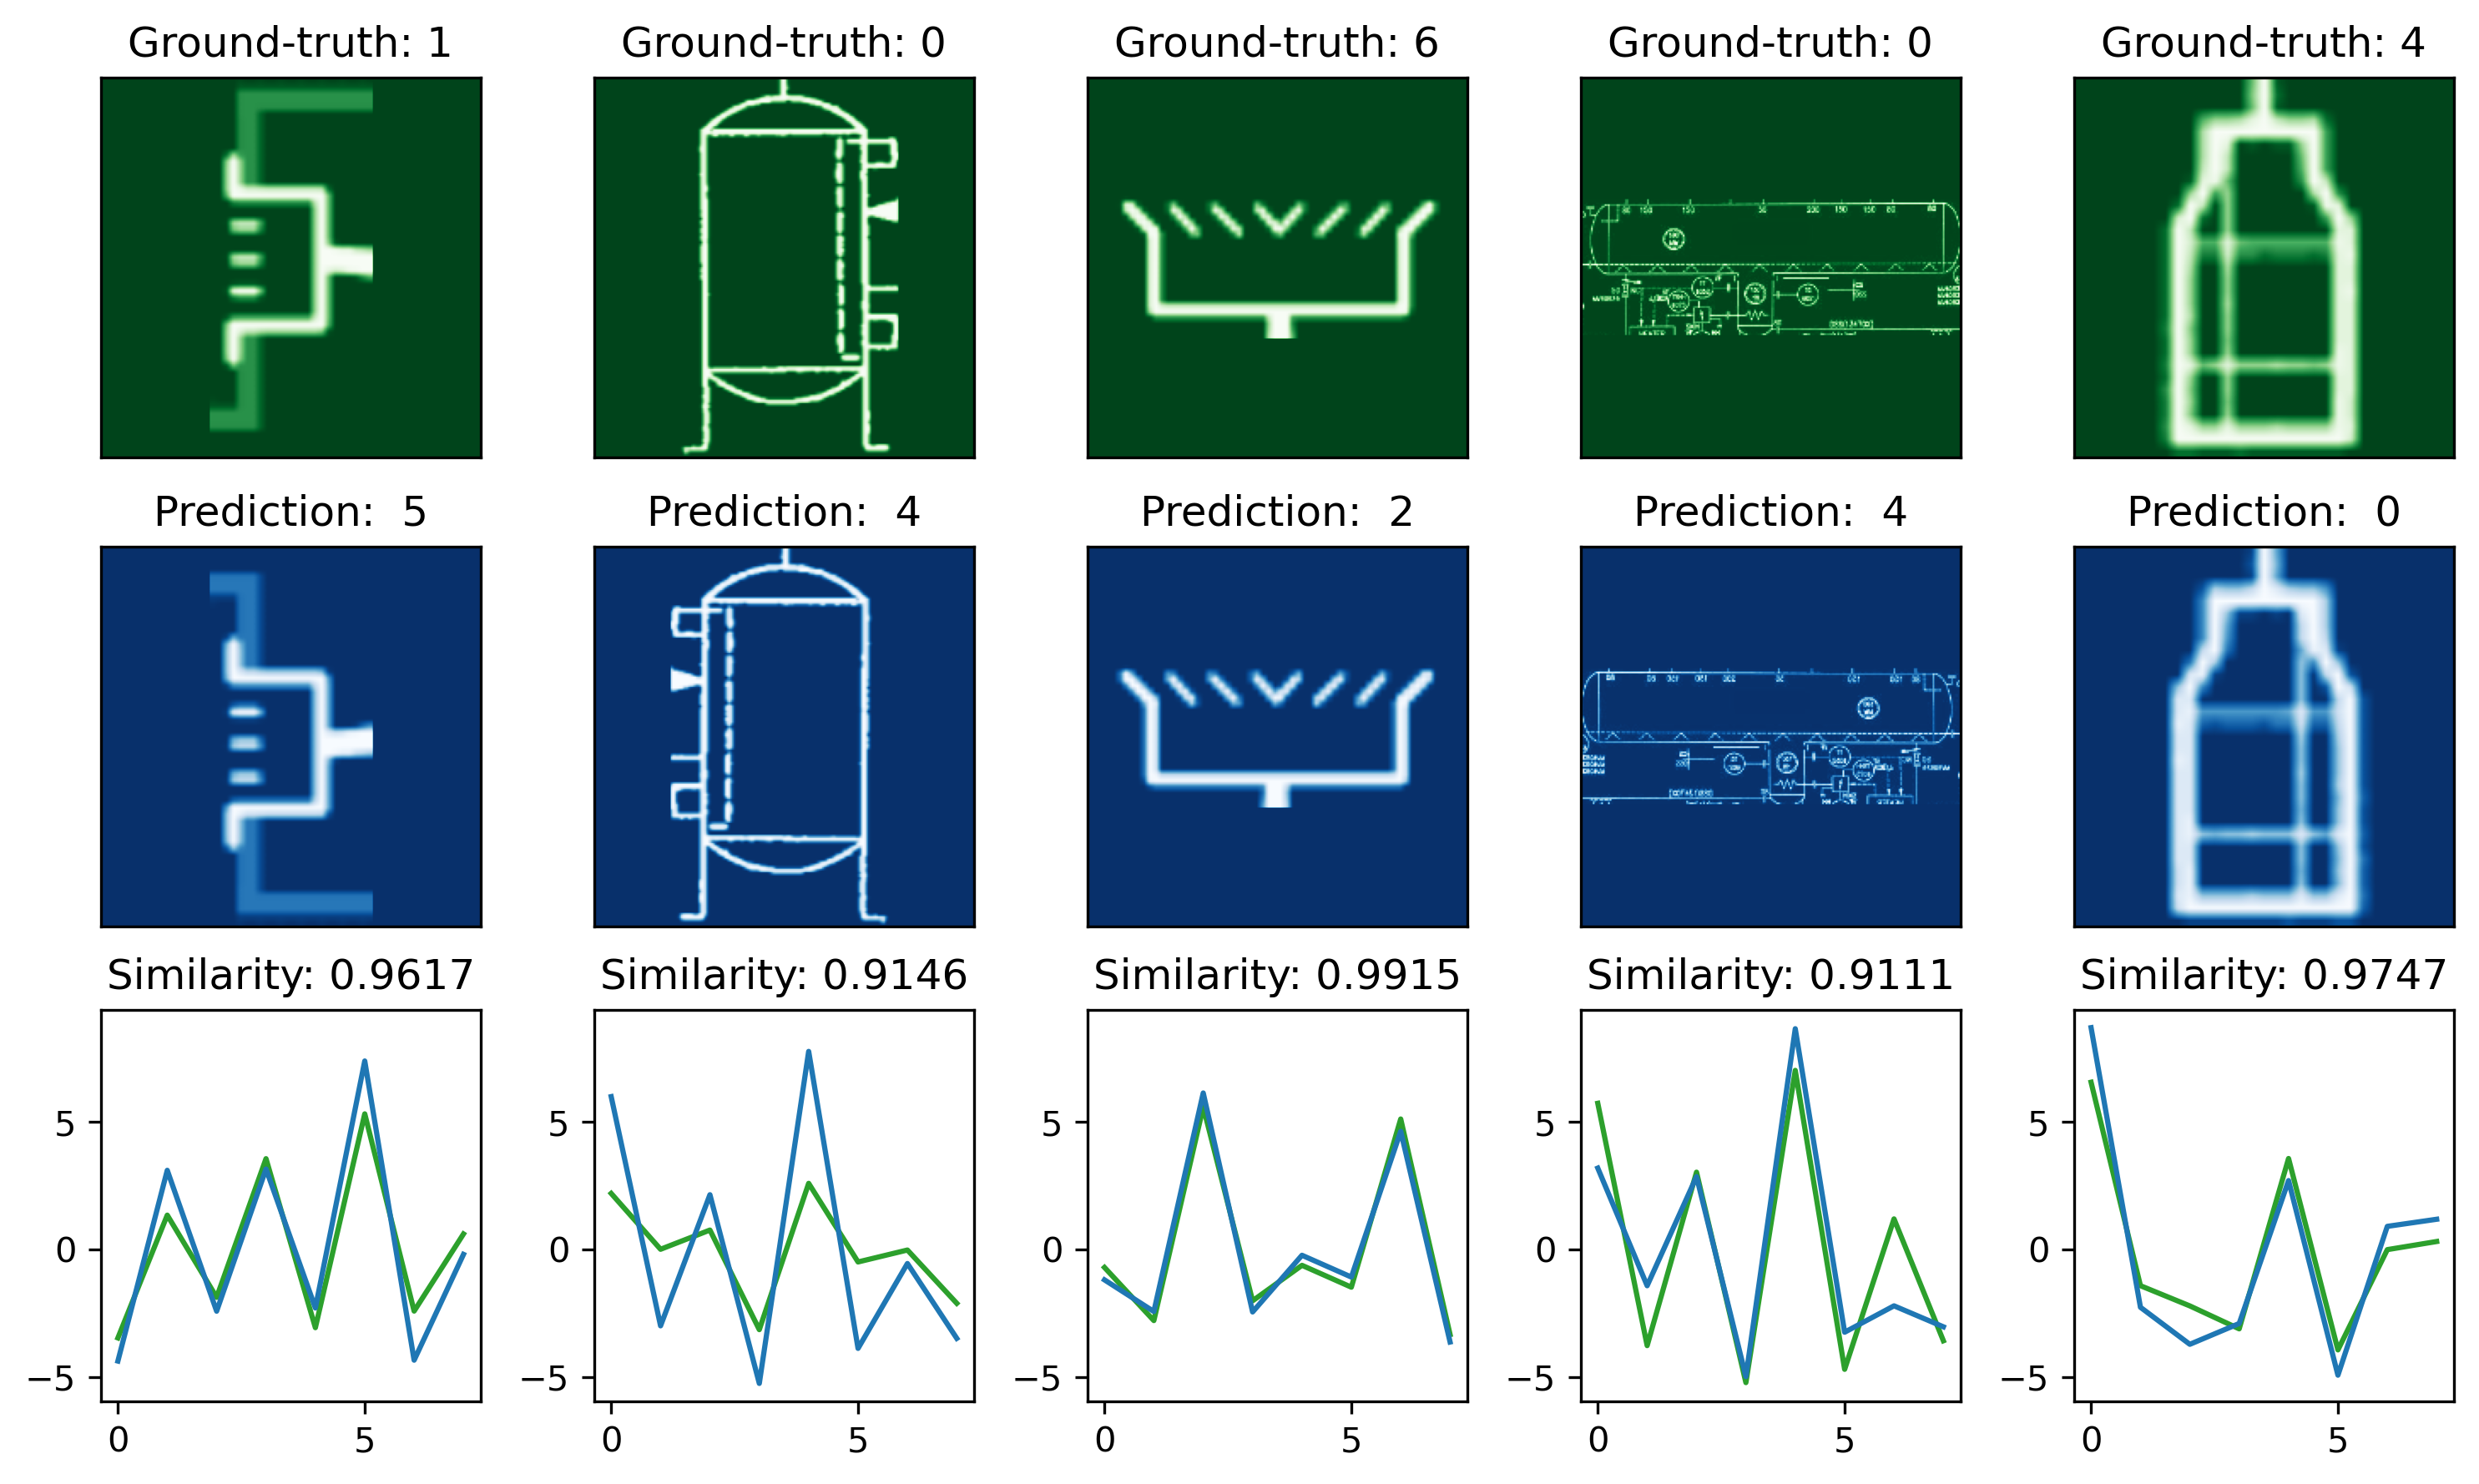

In [20]:
fig, ax = plt.subplots(nrows=3,ncols=5, figsize=(10, 6), dpi=300)
for i in range(5):
    j = i+80
    similar_object = true_but_amgiuous[j]
    ax[0][i].imshow(similar_object["input_image"], cmap="Greens")
    ax[1][i].imshow(similar_object["rotated_image"], cmap="Blues")
    # embedding0_mean = np.mean(embeddings[0][0])
    # embedding1_mean = np.mean(embeddings[1][0])
    # ax[2][i].axhline(y=embedding0_mean, color="tab:green", linestyle="--")
    # ax[2][i].axhline(y=embedding1_mean, color="tab:blue", linestyle="--")
    ax[2][i].plot(similar_object["original_embedding"], label="original", color="tab:green")
    ax[2][i].plot(similar_object["rotated_embedding"], label="reoriented", color="tab:blue")
    ax[0][i].set(yticks=[], xticks=[])
    ax[1][i].set(yticks=[], xticks=[])
    ax[0][i].set(title=f"Ground-truth: {similar_object['true_label']}")
    ax[1][i].set(title=f"Prediction:  {similar_object['prediction']}")
    ax[2][i].set(title=f"Similarity: {similar_object['similarity']:.4f}")
for i in ax[2][1:]:
    i.sharey(ax[2][0])
plt.subplots_adjust(wspace=0.1, hspace=0.005)
fig.tight_layout()

In [21]:

print(classification_report(y_true, y_pred))
print(classification_report(y_true, y_pred_corrected))

              precision    recall  f1-score   support

           0       0.57      0.62      0.59       525
           1       0.62      0.49      0.55       518
           2       0.66      0.49      0.56       541
           3       0.51      0.58      0.55       498
           4       0.62      0.57      0.59       523
           5       0.51      0.67      0.58       519
           6       0.62      0.48      0.54       541
           7       0.52      0.67      0.59       487

    accuracy                           0.57      4152
   macro avg       0.58      0.57      0.57      4152
weighted avg       0.58      0.57      0.57      4152

              precision    recall  f1-score   support

           0       0.78      0.77      0.77       525
           1       0.83      0.78      0.80       518
           2       0.84      0.70      0.76       541
           3       0.73      0.83      0.77       498
           4       0.79      0.76      0.77       523
           5       0.72 

In [22]:
conf_matrix = confusion_matrix(y_true, y_pred)
updated_conf_matrix = confusion_matrix(y_true, y_pred_corrected)
print(conf_matrix)

[[324  14   5  17  63   5  43  54]
 [ 10 255   4  17  10 143   1  78]
 [ 33  15 265  20  76  40  83   9]
 [  4   9   4 290   0  73  13 105]
 [ 88  34  39   8 299  22  13  20]
 [  8  44  15  67   9 349   4  23]
 [ 87   9  65  69  22  18 260  11]
 [ 13  32   2  77   4  29   4 326]]


Text(0.5, 0, 'Predicted')

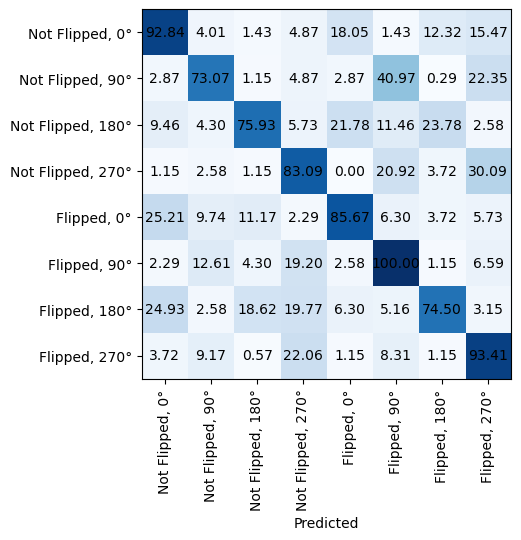

In [23]:
plt.imshow(conf_matrix/conf_matrix.max(), cmap="Blues")
# change the xticks to be the class names, not the indices
plt.xticks(range(8), list(DepictionDataset.labels_map.values()), rotation=90)
plt.yticks(range(8), list(DepictionDataset.labels_map.values()))
# add the confusion scores to the plot
for i in range(8):
    for j in range(8):
        plt.text(j, i, f'{conf_matrix[i, j]/conf_matrix.max()*100:.2f}', ha="center", va="center", color="black")
plt.xlabel("Predicted")

Text(0.5, 0, 'Predicted')

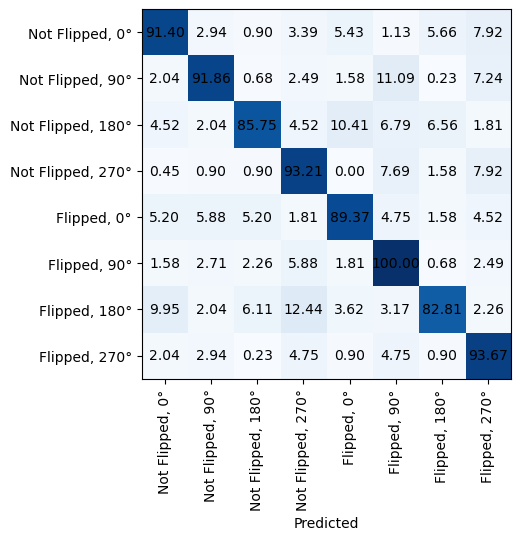

In [24]:
plt.imshow(updated_conf_matrix/updated_conf_matrix.max(), cmap="Blues")
# change the xticks to be the class names, not the indices
plt.xticks(range(8), list(DepictionDataset.labels_map.values()), rotation=90)
plt.yticks(range(8), list(DepictionDataset.labels_map.values()))
# add the confusion scores to the plot
for i in range(8):
    for j in range(8):
        plt.text(j, i, f'{updated_conf_matrix[i, j]/updated_conf_matrix.max()*100:.2f}', ha="center", va="center", color="black")
plt.xlabel("Predicted")

In [16]:
np.save("wrong.npy", wrong)
np.save("y_true.npy", y_true)
np.save("y_pred.npy", y_pred)
np.save("y_predictions.npy", y_predctions)

NameError: name 'wrong' is not defined

In [ ]:
y_pred[5]

4

Text(0.5, 1.0, 'ground_truth: 0, predicted: 7')

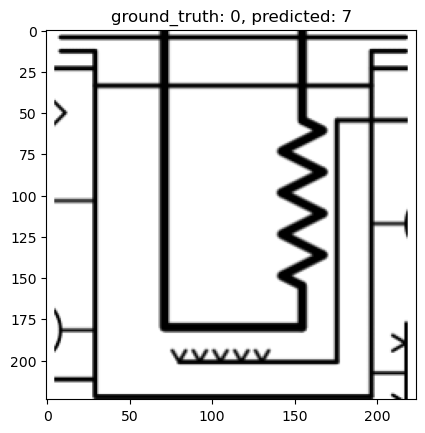

In [ ]:
index = 0
plt.imshow(test_data[wrong[index]][0].numpy()[0,:,:], cmap="gray")
plt.title(f"ground_truth: {test_data[wrong[index]][1]}, predicted: {y_pred[wrong[index]]}")

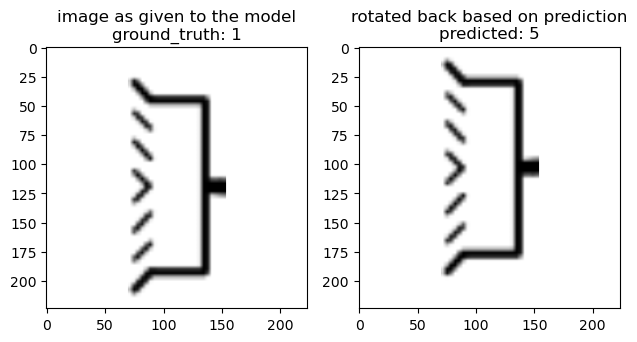

In [ ]:
def transform_back(orig_image, prediction):
    if type(orig_image) == torch.Tensor:
        orig_image = orig_image.numpy()[0,:,:]
    image = orig_image.copy()
    flip = False if prediction < 4 else True
    if prediction == 0 or prediction == 4:
        angle = False
        angle_string = "0°"
    elif prediction == 1 or prediction == 5:
        angle = cv2.ROTATE_90_COUNTERCLOCKWISE
        angle_string = "90°"
    elif prediction == 2 or prediction == 6:
        angle = cv2.ROTATE_180
        angle_string = "180°"
    elif prediction == 3 or prediction == 7:
        angle = cv2.ROTATE_90_CLOCKWISE
        angle_string = "270°"
    image = cv2.rotate(image, angle) if angle is not False else image
    image = cv2.flip(image, 1) if flip is not False else image
    # print(f"{flip=}, {angle_string}")
    return image
def transform_image(orig_image, prediction):
    image = orig_image.copy()
    flip = False if prediction < 4 else True
    if prediction == 0 or prediction == 4:
        angle = False
        angle_string = "0°"
    elif prediction == 1 or prediction == 5:
        angle = cv2.ROTATE_90_CLOCKWISE
        angle_string = "90°"
    elif prediction == 2 or prediction == 6:
        angle = cv2.ROTATE_180
        angle_string = "180°"
    elif prediction == 3 or prediction == 7:
        angle = cv2.ROTATE_90_COUNTERCLOCKWISE
        angle_string = "270°"
    image = cv2.flip(image, 1) if flip is not False else image
    image = cv2.rotate(image, angle) if angle is not False else image
    # print(f"{flip=}, {angle_string}")
    return image
    
# next to each other, the ground truth and the prediction
def display_prediction(index):
    # print(index)
    orig_image = test_data[wrong[index]][0].numpy()[0,:,:]
    correct = test_data[wrong[index]][1]
    predicted = y_pred[wrong[index]]
    plt.subplot(1, 2, 1)
    image = transform_back(orig_image, correct)
    plt.imshow(orig_image, cmap="gray")
    plt.title(f"image as given to the model\nground_truth: {correct}")
    plt.subplot(1, 2, 2)
    image = transform_back(image, predicted)
    plt.imshow(image, cmap="gray")
    plt.title(f"rotated back based on prediction\npredicted: {predicted}")
    plt.tight_layout()
    plt.show()

index = 9
display_prediction(index)


In [ ]:

# similarity score
def get_similarity_score(index, plot=False):
    input_image = test_data[wrong[index]][0].numpy().astype("float32")
    input_image = torch.from_numpy(input_image)
    input_image = input_image.unsqueeze(0)
    embedding1 = model(input_image)
    prediction = torch.argmax(embedding1, dim=1)
    rotated_image = input_image
    if prediction == 1 or prediction == 5:
        rotated_image = torchvision.transforms.functional.rotate(input_image, 90)
    elif prediction == 2 or prediction == 6:
        rotated_image = torchvision.transforms.functional.rotate(input_image, 180)
    elif prediction == 3 or prediction == 7:
        rotated_image = torchvision.transforms.functional.rotate(input_image, 270)    
    second_image = torchvision.transforms.functional.vflip(rotated_image) if prediction > 3 else rotated_image
    
    embedding2 = model(second_image)
    embedding1, embedding2 = embedding1.detach().numpy(), embedding2.detach().numpy()
    similarity = cosine_similarity(embedding1, embedding2)
    if plot:
        plt.subplot(2, 2, 1)
        plt.plot(range(8), embedding1[0], ls="--") 
        plt.plot(range(8), embedding2[0], ls="-.")
        plt.title(f"similarity: {similarity[0][0]:.2f}")
        plt.subplot(2, 2, 3)
        plt.imshow(input_image[0,0,:,:], cmap="gray")
        plt.xticks([]), plt.yticks([])
        plt.subplot(2, 2, 4)
        plt.imshow(second_image[0,0,:,:], cmap="gray")
        plt.xticks([]), plt.yticks([])
    return int(prediction), y_true[wrong[index]], similarity[0][0]
    

(2, 4, 0.26105374)

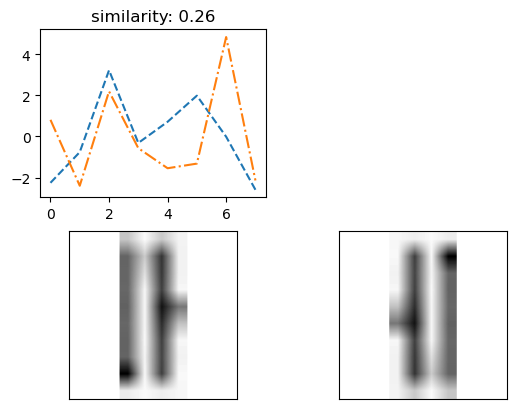

In [ ]:
get_similarity_score(26, plot=True)

Output()

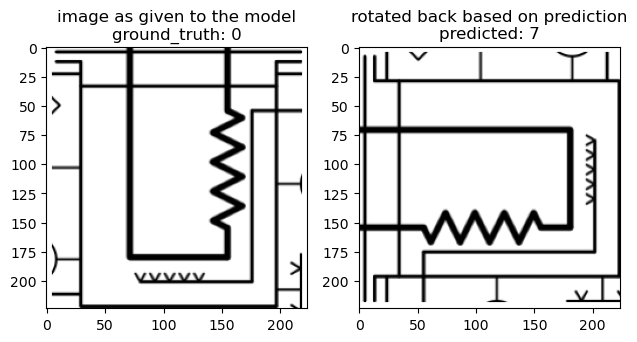

In [ ]:
button_correct = widgets.Button(description="Correct", color=dict(button_color="#00dd00"))
button_wrong = widgets.Button(description="Wrong", style=dict(button_color="#ff3300"))
output = widgets.Output()
display(widgets.HBox((button_correct, button_wrong)), output)
index = 0
display_prediction(index)
index +=1
correct_count = 0
wrong_count = 0
def on_button_wrong_clicked(b):
    global index, correct_count, wrong_count
    wrong_count +=1
    output.clear_output()
    with output:
        display_prediction(index)
        index +=1
        print(f"progress: {index}/{len(wrong)} -- {index/len(wrong)}\n{correct_count=}, {wrong_count=}")
def on_button_correct_clicked(c):
    global index, correct_count, wrong_count
    correct_count +=1
    output.clear_output()
    with output:
        display_prediction(index)
        index +=1
        print(f"progress: {index}/{len(wrong)} -- {index/len(wrong)}\n{correct_count=}, {wrong_count=}")
button_wrong.on_click(on_button_wrong_clicked)
button_correct.on_click(on_button_correct_clicked)